In [1]:
# This notebook is developed for Python 3
# List of analytics libraries: 
# Sklearn 0.23.2
# XGBoost 1.3.3
# Pandas 1.1.3
# Numpy 1.18.5
# Seaborn 0.11.0

In [2]:
import sklearn
import xgboost as xgb
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
# ML Algorithms used 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Dataset Loading and EDA

In [5]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
train.describe

<bound method NDFrame.describe of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                 

### Visualizing the data properities

In [9]:
# Checking the number of rows having null values
train[train.columns[train.isnull().any()]].isnull().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

0    0.616162
1    0.383838
Name: Survived, dtype: float64


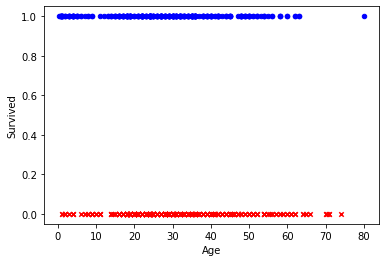

In [10]:
print(train['Survived'].value_counts()/len(train))
fig, ax = plt.subplots()
markers = ['x','o']
for i in range(2):
    if i == 0:
        color = 'red'
    else: color = 'blue'
    train[train['Survived'].eq(i)].plot.scatter(x='Age', 
                                              y='Survived', 
                                              marker=markers[i],color = color,
                                              ax=ax)

<AxesSubplot:>

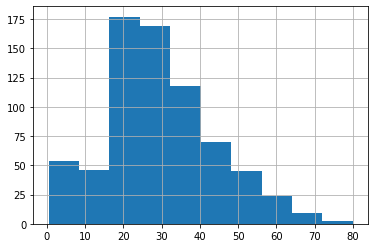

In [11]:
train['Age'].hist()

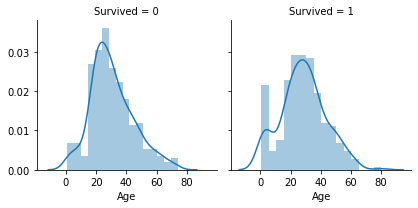

In [12]:
# Age/survived columns comparison 
graph = sns.FacetGrid(train, col='Survived')
graph.map(sns.distplot, "Age")

Text(0, 0.5, 'Probability')

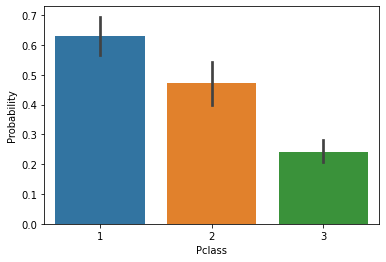

In [14]:
# Porbability of surviving based on the Pclass
graph = sns.barplot(x="Pclass",y="Survived",data=train)
graph.set_ylabel("Probability")

# Feature Exploration, Engineering and Cleaning

In [15]:
# Applying the pipline on training/testing data
full_dataset = [train, test]

In [16]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Column: Name

In [18]:
# Some features that can be created from the Name column

# Name Length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Featurizing titles from names using Regular Expression
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_dataset:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [21]:
full_dataset[0].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,16,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,23,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,30,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,49,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,35,Mrs


[None, None, None, None, None, None, None, None, None, None]

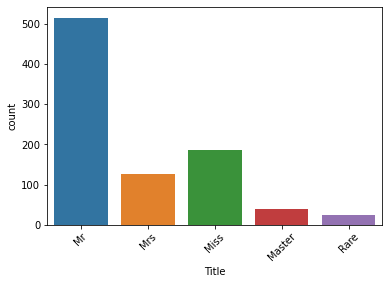

In [22]:
graph = sns.countplot(x="Title",data=full_dataset[0])
plt.setp(graph.get_xticklabels(), rotation=45) 

#### Column: Cabin

In [24]:
# Making the column a boolean one 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#### Column: Family Size

In [27]:
# FamilySize can be the sum of SibSp and Parch + 1
for dataset in full_dataset:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Adding anther column for passengers travelling along
for dataset in full_dataset:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

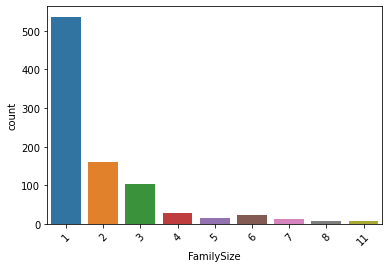

In [28]:
graph = sns.countplot(x="FamilySize",data=full_dataset[0])
plt.setp(graph.get_xticklabels(), rotation=45) 

In [29]:
# We saw couple of rows have null values for some columns, let's get that fixed

In [33]:
# Column: Embarked
for dataset in full_dataset:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Column: Fare 
for dataset in full_dataset:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

#### Categorizing Columns

In [35]:
# Column: Fare
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [36]:
# Making Age column a categorical
for dataset in full_dataset:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [37]:
 # Columns: Titles, sex, embarked, Fare, Age
for dataset in full_dataset:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int) 
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

### Feature Selection

In [12]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

# Visualisations

In [13]:
training_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']

In [14]:
train.head(10)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,1,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3


<AxesSubplot:title={'center':'Pearson correlation of features'}>

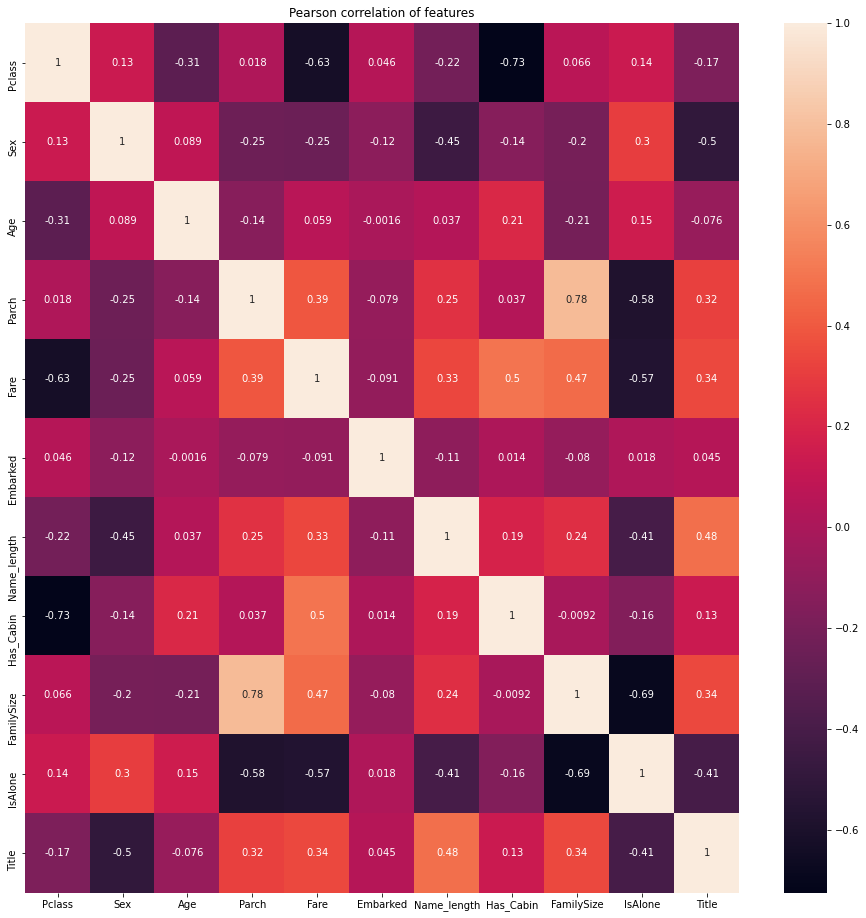

In [51]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,16))
plt.title('Pearson correlation of features')
sns.heatmap(train.astype(float).corr(), annot=True)

# Ensembling & Stacking models

In [16]:
# Model Class to be used for different ML algorithms
class ClassifierModel(object):
    def __init__(self, clf, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def predict(self, x):
        return self.clf.predict(x)

In [17]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [18]:
def trainModel(model, x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

## Random Forest Classifier

In [20]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores = trainModel(rfc_model,x_train, y_train, x_test, 5, 0) # Random Forest
rfc_scores

array([0.82681564, 0.80337079, 0.81460674, 0.79213483, 0.85393258])

In [22]:
# Getting features importance 
rfc_features = rfc_model.feature_importances(x_train,y_train)
rfc_features

array([0.10891369, 0.24259515, 0.03357986, 0.01771431, 0.04997678,
       0.02303345, 0.10128659, 0.06423284, 0.07494216, 0.01282861,
       0.27089655])

## Extra Trees Classifier

In [24]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
etc_model = ClassifierModel(clf=ExtraTreesClassifier, params=et_params)
etc_scores = trainModel(etc_model,x_train, y_train, x_test, 5, 0) # Random Forest
etc_scores

array([0.81005587, 0.80337079, 0.8258427 , 0.78651685, 0.87078652])

In [25]:
# Getting features importance 
etc_features = etc_model.feature_importances(x_train, y_train)
etc_features

array([0.1276258 , 0.37978   , 0.03032509, 0.01631745, 0.05675768,
       0.02746554, 0.04848809, 0.08636034, 0.04400544, 0.02167755,
       0.16119701])

## AdaBoost Classifier

In [28]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}
ada_model = ClassifierModel(clf=AdaBoostClassifier, params=ada_params)
ada_scores = trainModel(ada_model,x_train, y_train, x_test, 5, 0) # Random Forest
ada_scores

array([0.81005587, 0.76966292, 0.80337079, 0.81460674, 0.80337079])

In [29]:
# Getting features importance 
ada_features = ada_model.feature_importances(x_train, y_train)
ada_features

array([0.032, 0.012, 0.014, 0.066, 0.04 , 0.01 , 0.692, 0.014, 0.052,
       0.002, 0.066])

## XGBoost Classifier

In [30]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
gbc_model = ClassifierModel(clf=GradientBoostingClassifier, params=gb_params)
gbc_scores = trainModel(gbc_model,x_train, y_train, x_test, 5, 0) # Random Forest
gbc_scores

array([0.76536313, 0.78089888, 0.82022472, 0.78089888, 0.84269663])

In [31]:
# Getting features importance 
gbc_features = gbc_model.feature_importances(x_train,y_train)
gbc_features 

array([0.08562728, 0.0128771 , 0.05289445, 0.01346906, 0.05253793,
       0.02651496, 0.16614431, 0.03861304, 0.11272447, 0.00787902,
       0.43071837])

## Support Vector Classifier

In [32]:
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
svc_model = ClassifierModel(clf=SVC, params=svc_params)
svc_scores = trainModel(svc_model,x_train, y_train, x_test, 5, 0) # Random Forest
svc_scores

array([0.83240223, 0.80898876, 0.82022472, 0.7752809 , 0.83707865])

### Features Importance 

In [34]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': train.columns.values,
    'Random Forest feature importances': rfc_features,
    'Extra Trees  feature importances': etc_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gbc_features
    })

In [35]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.108914,0.127626,0.032,0.085627,0.088542
1,Sex,0.242595,0.379780,0.012,0.012877,0.161813
2,Age,0.033580,0.030325,0.014,0.052894,0.032700
3,Parch,0.017714,0.016317,0.066,0.013469,0.028375
4,Fare,0.049977,0.056758,0.040,0.052538,0.049818
5,Embarked,0.023033,0.027466,0.010,0.026515,0.021753
6,Name_length,0.101287,0.048488,0.692,0.166144,0.251980
7,Has_Cabin,0.064233,0.086360,0.014,0.038613,0.050802
8,FamilySize,0.074942,0.044005,0.052,0.112724,0.070918
9,IsAlone,0.012829,0.021678,0.002,0.007879,0.011096


In [36]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [41]:
acc_pred_train = pd.DataFrame ({'RandomForest': rfc_scores.ravel(),
     'ExtraTrees': etc_scores.ravel(),
     'AdaBoost': ada_scores.ravel(),
      'GradientBoost': gbc_scores.ravel()
    })
acc_pred_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.826816,0.810056,0.810056,0.765363
1,0.803371,0.803371,0.769663,0.780899
2,0.814607,0.825843,0.803371,0.820225
3,0.792135,0.786517,0.814607,0.780899
4,0.853933,0.870787,0.803371,0.842697


<AxesSubplot:title={'center':'Pearson correlation of features'}>

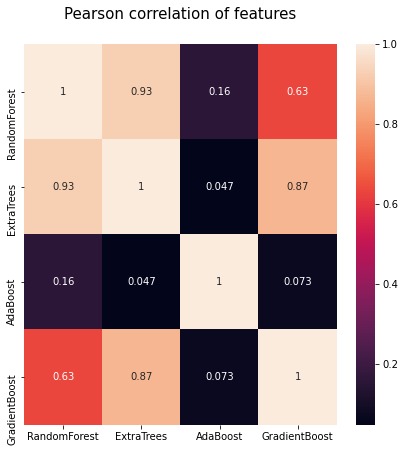

In [45]:
colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(acc_pred_train.astype(float).corr(), annot=True)

In [46]:
x_train = np.concatenate(( etc_pred_train, rfc_pred_train, adac_pred_train, gbc_pred_train, svc_pred_train), axis=1)
x_test = np.concatenate(( etc_pred_test, rfc_pred_test, adac_pred_test, gbc_pred_test, svc_pred_test), axis=1)

NameError: name 'etc_pred_train' is not defined

In [61]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[14:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
from sklearn.metrics import accuracy_score

In [68]:
accuracy_score(y_test, predictions)

NameError: name 'y_test' is not defined